# CVRP HW2 - part 2
In this part, you will implement **unconditional** and **conditional** PixelCNN on MNIST dataset.
To have faster training efficency, GPU acceleration is recommended. However, don't worry if you reach your GPU usage limit on Colab. This part can still be completed within a reasonable timeframe using a standard CPU.

PixelCNNs are a type of autoregressive generative model that generate images by modeling the joint distribution of pixels as a product of conditional distributions. In PixelCNN, the pixels are generated one by one in a specific order, with each pixel conditioned on the previously generated pixels. The model uses masked convolutions to ensure that the prediction of each pixel only depends on the already generated pixels, following the raster scan order. For more details, please refer to Lecture 13.

Some notes:
- This part takes 50 points in total
- There is **no questions** in this part
- If you made any modifications on the cells with "DO NOT MODIFY" label, please be sure to write a detailed README, otherwise, TA will have a hard time grading your code...
- If you find it's hard to put all the things into a single notebook, you can have additional files. Make sure you have a README as well.
- Please zip all the notebooks or files you have to a compressed zip file before submission.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### MNIST dataset loader
Please do not modify this cell

In [2]:
# NOTE: DO NOT MODIFY

def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
							train = True,
							download = True,
							transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
							train = False,
							download = True,
							transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
										batch_size = batch_size,
										shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
										batch_size = batch_size,
										shuffle = False)


## **PixelCNN**

Tasks:
- [15 pts] Implement Masked Convolution by finishing the `MaskedConv2d()` function
- [15 pts] Implement PixelCNN with your `MaskedConv2d()`
- The training function for unconditional PixelCNN is provided, there is no need to modify `train()`

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0

        for iter, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

    return losses


### Masked Convolution
The `MaskedConv2d()` function applies a mask to the convolutional filters in a 2D convolutional layer. The mask ensures that each pixel is only influenced by the pixels that have been generated before it. The function should allow for both type A and type B masks, where type A masks do not allow the central pixel to influence itself, and type B masks do.

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, stride=1, padding=0, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        
        assert mask_type in ['A', 'B'], "mask_type must be either 'A' or 'B'"
        self.register_buffer('mask', torch.ones_like(self.weight))
        kH, kW = self.kernel_size
        center_h, center_w = kH // 2, kW // 2
        
        # here i zero out pixels in the filter that shouldn't influence the current pixel
        self.mask[:, :, center_h + 1:] = 0
        self.mask[:, :, center_h, center_w + (mask_type == 'B'):] = 0

    def forward(self, x):
        # below i apply the mask to the convolutional filters before forward(x)
        self.weight.data *= self.mask
        return super().forward(x)

### Implement PixelCNN
Using your `MaskedConv2d()` function, implement the PixelCNN architecture. Your implementation should include several masked convolutional layers, nonlinear activations, and any necessary normalization layers. Ensure that your model is capable of generating images pixel by pixel.

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.masked_conv = MaskedConv2d()
        
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=7, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=7, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ) for _ in range(7)  
        ])
        
        self.output_layers = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        out = self.masked_conv(x)
        
        for conv_block in self.conv_layers:
            residual = out
            out = conv_block(out)
            out = out + residual
            out = F.relu(out)
        
        out = self.output_layers(out)
        
        return out

### Training
Train your PixelCNN model on the MNIST dataset. We will use Cross-Entropy Loss (BCE) as the training objective. This is equal to maximizing likelihood for binary sequence autoregressive models. After training, evaluate the model using the provided code for unconditional generation of MNIST digits. You may need to adjust hyperparameters such as the learning rate, number of epochs, and batch size to achieve good results.

In [ ]:
epochs = 20
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)

# saving the model in case i lose kernel
model_save_path = 'pixelcnn_mnist.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': epochs,
    'loss': log
}, model_save_path)

print(f"Model saved to {model_save_path}")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Average Loss: 0.0889
Epoch [2/100], Average Loss: 0.0045
Epoch [3/100], Average Loss: 0.0014
Epoch [4/100], Average Loss: 0.0007
Epoch [5/100], Average Loss: 0.0004
Epoch [6/100], Average Loss: 0.0002
Epoch [7/100], Average Loss: 0.0002
Epoch [8/100], Average Loss: 0.0001
Epoch [9/100], Average Loss: 0.0001
Epoch [10/100], Average Loss: 0.0001
Epoch [11/100], Average Loss: 0.0000
Epoch [12/100], Average Loss: 0.0000
Epoch [13/100], Average Loss: 0.0000
Epoch [14/100], Average Loss: 0.0000
Epoch [15/100], Average Loss: 0.0000
Epoch [16/100], Average Loss: 0.0000
Epoch [17/100], Average Loss: 0.0000
Epoch [18/100], Average Loss: 0.0000
Epoch [19/100], Average Loss: 0.0000
Epoch [20/100], Average Loss: 0.0000
Epoch [21/100], Average Loss: 0.0000
Epoch [22/100], Average Loss: 0.0000
Epoch [23/100], Average Loss: 0.0000
Epoch [24/100], Average Loss: 0.0000
Epoch [25/100], Average Loss: 0.0000
Epoch [26/100], Average Loss: 0.0000
Epoch [27/100], Average Loss: 0.0000
Epoch [28/

## The loss hits 0 after 11th epoch and stays so till 100th epoch. it ran for 100 epochs since i was from the system otherwise i could have saved some significant training time. I ran it in another cell for 10 epochs that i deleted for submission to confirm if the performace remained similar.

### Evaluation (Reconstruction)
The following code is to verify your PixelCNN is able to reconstruct the image from MNIST test set.

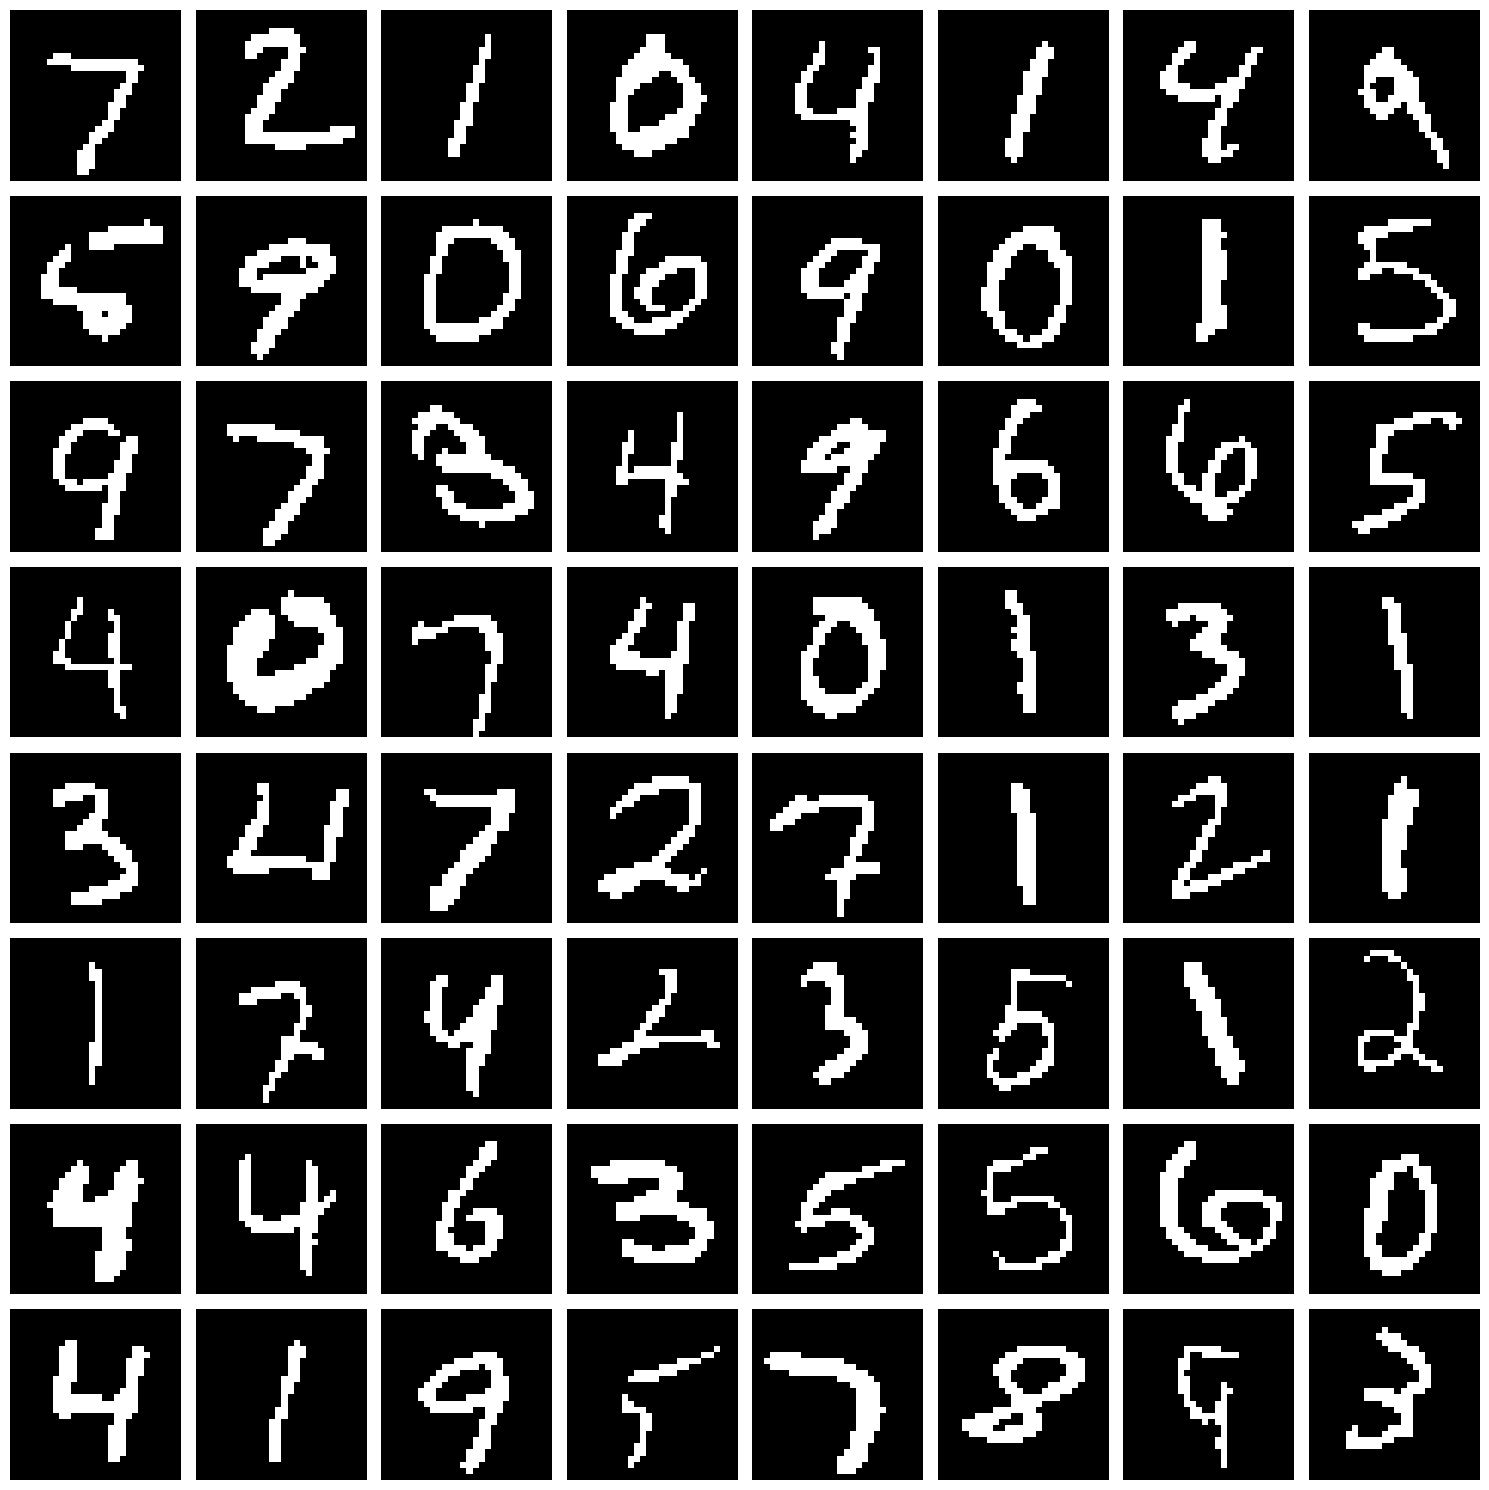

In [7]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Evaluation (Generation)

In [1]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'torch' is not defined

## **Conditional PixelCNN**
Conditional PixelCNNs extend the basic PixelCNN model by conditioning the generation process on additional information, such as class labels. In this part, you will implement and train a Conditional PixelCNN on the MNIST dataset, where the model is conditioned on the digit class labels.

Tasks:
- [5 pts] Extend your implementation of the `ConditionalMaskedConv2d()` function to incorporate a conditional bias based on class labels
- [5 pts] Using your `ConditionalMaskedConv2d()` function, implement the Conditional PixelCNN architecture
- [5 pts] Write your own training function. The training process is similar as in unconditional PixelCNN with some changes
- [5 pts] Train your Conditional PixelCNN on the MNIST dataset. After training, evaluate the model’s performance on the test set by generating images conditioned on specific digit classes.

In [ ]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []
    
    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        
        for iter, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = F.one_hot(labels, num_classes=n_classes).float()
            tgt = images.clone()
            pred = model(images, labels_onehot)
            loss = bce(pred, tgt)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())
        
        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')
    
    return losses

### Conditional Masked Convolution
The conditional bias should be added to the output of each convolutional layer $l$ as follows:

$W_l * x + b_l + V_{ly}$

where $W_l * x + b_l$ represents the masked convolution, $V_l$ is a 2D weight matrix, and $y$ is the one-hot encoded class label. The conditional bias $V_{ly}$ should be broadcasted spatially and added to the output channel-wise.

In [ ]:
class ConditionalMaskedConv2d(MaskedConv2d):
    def __init__(self):
        super().__init__()
        self.conditional_weights = nn.Parameter(torch.randn(64, 10))  # V_l matrix
        nn.init.xavier_uniform_(self.conditional_weights)

    def forward(self, x, class_condition):
        conv_out = super().forward(x)
        conditional_bias = torch.matmul(class_condition, self.conditional_weights.t())
        conditional_bias = conditional_bias.unsqueeze(-1).unsqueeze(-1)
        return conv_out + conditional_bias

### Implement Conditional PixelCNN
Using your `ConditionalMaskedConv2d()` function, implement the Conditional PixelCNN architecture. Your model should include several conditional masked convolutional layers, with the class label influencing each layer’s output through the conditional bias. The overall architecture should closely resemble the regular PixelCNN but with the additional conditioning on class labels.

In [ ]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.masked_conv = ConditionalMaskedConv2d()
        
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=7, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=7, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ) for _ in range(7)  
        ])
        
        self.output_layers = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()  
        )

    def forward(self, x, class_condition):
        out = self.masked_conv(x, class_condition)
        
        for conv_block in self.conv_layers:
            residual = out
            out = conv_block(out)
            out = out + residual 
            out = F.relu(out)
        
        out = self.output_layers(out)
        
        return out

### Training

In [ ]:
epochs = 20
n_classes = 10
model = ConditionalPixelCNN(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)

model_save_path = 'conditional_pixelcnn_mnist.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': epochs,
    'n_classes': n_classes,
    'loss': log
}, model_save_path)

print(f"Model saved to {model_save_path}")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Average Loss: 0.0735
Epoch [2/100], Average Loss: 0.0037
Epoch [3/100], Average Loss: 0.0012
Epoch [4/100], Average Loss: 0.0006
Epoch [5/100], Average Loss: 0.0003
Epoch [6/100], Average Loss: 0.0002
Epoch [7/100], Average Loss: 0.0001
Epoch [8/100], Average Loss: 0.0001
Epoch [9/100], Average Loss: 0.0001
Epoch [10/100], Average Loss: 0.0000
Epoch [11/100], Average Loss: 0.0000
Epoch [12/100], Average Loss: 0.0000
Epoch [13/100], Average Loss: 0.0000
Epoch [14/100], Average Loss: 0.0000
Epoch [15/100], Average Loss: 0.0000
Epoch [16/100], Average Loss: 0.0000
Epoch [17/100], Average Loss: 0.0000
Epoch [18/100], Average Loss: 0.0000
Epoch [19/100], Average Loss: 0.0000
Epoch [20/100], Average Loss: 0.0000
Epoch [21/100], Average Loss: 0.0000
Epoch [22/100], Average Loss: 0.0000
Epoch [23/100], Average Loss: 0.0000
Epoch [24/100], Average Loss: 0.0000
Epoch [25/100], Average Loss: 0.0000
Epoch [26/100], Average Loss: 0.0000
Epoch [27/100], Average Loss: 0.0000
Epoch [28/

## Here it converges even earlier :)

### Evaluation (Reconstruction)

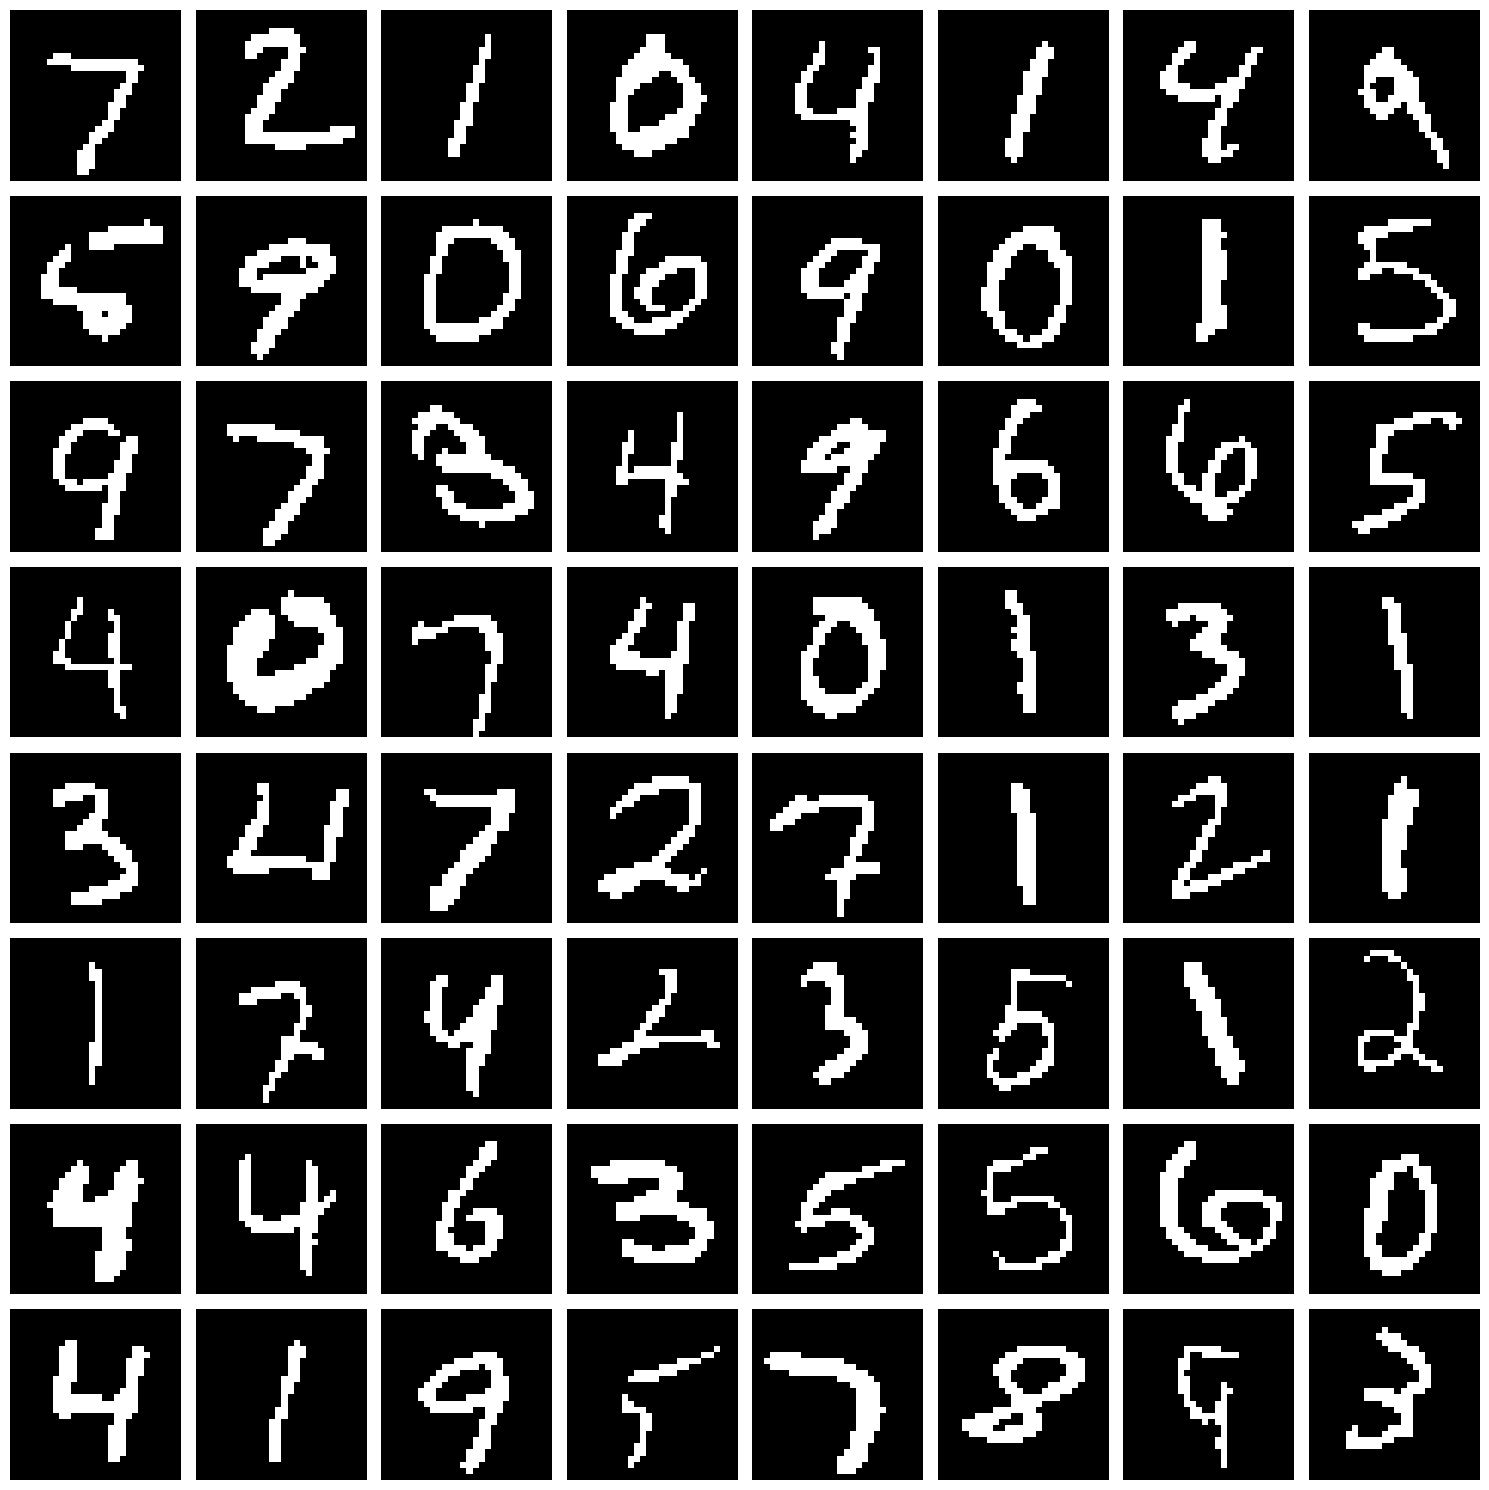

In [13]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Evaluation (Generation)

In [2]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'torch' is not defined

In [ ]:
I dont know why generation is doing so poorly compared to reconstruction